In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    # !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jmdggykl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jmdggykl
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=14771015cc42b9edafffb4955a003203dc7ff4d2125516754693d95a08880285
  Stored in directory: /tmp/pip-ephem-wheel-cache-aizsym3z/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [ ]:
image = cv2.imread('/content/d7597_sketch_1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

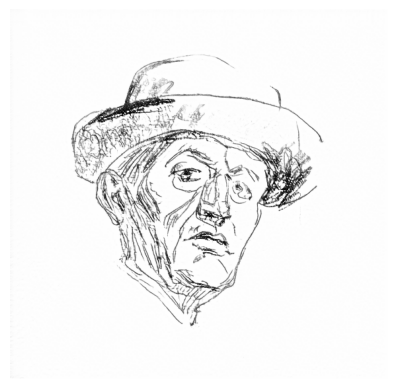

In [ ]:
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/drive/MyDrive/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To generate masks, just run `generate` on an image.

In [ ]:
image = cv2.imread('/content/d7597_sketch_1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

11
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

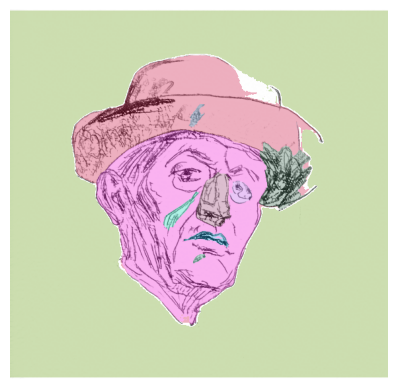

In [ ]:
plt.figure()
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=8,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=200,  # Requires open-cv to run post-processing
)

7


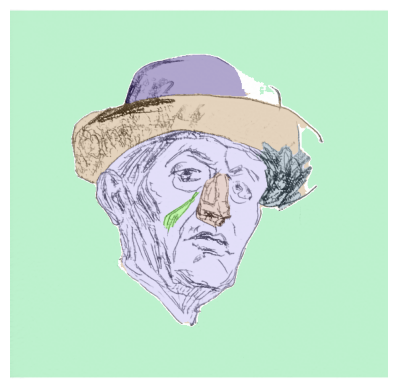

In [ ]:
image = cv2.imread('/content/d7597_sketch_1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks2 = mask_generator_2.generate(image)
print(len(masks2))
plt.figure()
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()


In [ ]:
import pandas as pd

# Assuming masks2 is your list of dictionaries containing mask data

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(masks2)

# Define the filename for the CSV file
filename = 'masks2_data.csv'

# Write DataFrame to CSV file
df.to_csv(filename, index=False)


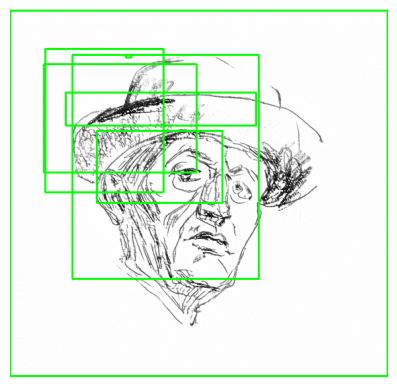

In [ ]:
import cv2
import pandas as pd
from matplotlib import pyplot as plt

# Function to draw bounding boxes on an image
def draw_boxes(image, bboxes):
    for bbox in bboxes:
        bbox = bbox.strip('[]')  # Remove square brackets
        x1, y1, x2, y2 = map(int, bbox.split(','))
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Read the CSV file containing bounding boxes
def read_bboxes_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    bboxes = df['bbox'].tolist()
    return bboxes

# Main function
def main():
    # Path to input image and CSV file
    image_path = '/content/d7597_sketch_1.png'
    csv_file = '/content/masks2_data.csv'

    # Read input image
    image = cv2.imread(image_path)

    # Read bounding boxes from CSV
    bboxes = read_bboxes_from_csv(csv_file)

    # Draw bounding boxes on the image
    draw_boxes(image, bboxes)

    # Convert BGR to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes using matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


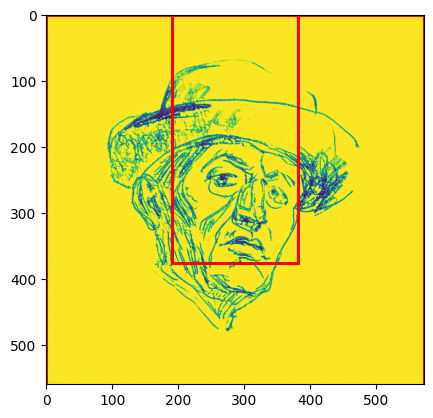

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import csv

# Load image
image_path = '/content/d7597_sketch_1.png'
image = Image.open(image_path)

# Create figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Load crop box values from CSV
csv_file = '/content/masks2_data.csv'

with open(csv_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        # Extract crop_box values from the specified column
        crop_box = row['crop_box'].strip('[]')
        x1, y1, x2, y2 = map(float, crop_box.split(','))  # Convert to float

        # Draw bounding box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

# Show the plot
plt.show()


In [ ]:
image.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Read the image
image = cv2.imread('/content/Munch-017.jpg')

# Convert image to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert the grayscale image to RGB for display
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

masks2 = mask_generator_2.generate(image)
plt.figure()
plt.imshow(image)
# Assuming `show_anns` is a function that overlays annotations on the image
show_anns(masks2)
plt.axis('off')
plt.show()


In [ ]:
import pandas as pd

# Assuming masks2 is your list of dictionaries containing mask data

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(masks2)

# Define the filename for the CSV file
filename = 'masks2_data.csv'

# Write DataFrame to CSV file
df.to_csv(filename, index=False)


In [ ]:
from PIL import Image
import numpy as np

# Assuming masks2 is your list of dictionaries containing mask data

# Iterate over each mask
for i, mask_data in enumerate(masks2):
    # Convert the segmentation array to a binary mask
    segmentation = np.array(mask_data['segmentation'], dtype=np.uint8) * 255
    mask_image = Image.fromarray(segmentation)

    # Define the filename for the PNG file
    filename = f'mask_{i}.png'

    # Save the mask image as PNG
    mask_image.save(filename)

    print(f"Mask {i} saved as {filename}")


In [ ]:
plt.figure()
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()